<a href="https://colab.research.google.com/github/Ragnarok540/sympy-tutorial/blob/main/2_mass_2_spring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import sympy as smp
import sympy.physics.mechanics as smp_mech
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import PillowWriter
from matplotlib.lines import Line2D
from matplotlib.transforms import Affine2D

In [ ]:
smp_mech.init_vprinting()

m_1, m_2, k, t = smp.symbols('m_1 m_2 k t')
x_1, x_2 = smp_mech.dynamicsymbols('x_1 x_2')

x_1_dot = smp.diff(x_1, t)
x_1_ddot = smp.diff(x_1_dot, t)
x_2_dot = smp.diff(x_2, t)
x_2_ddot = smp.diff(x_2_dot, t)

T = smp.Rational(1, 2) * m_1 * x_1_dot**2 + smp.Rational(1, 2) * m_2 * x_2_dot**2
V = smp.Rational(1, 2) * k * x_2**2 + smp.Rational(1, 2) * k * (x_1 - x_2)**2
L = T - V
L

eqn1 = smp.diff(smp.diff(L, x_1_dot), t) - smp.diff(L, x_1)
eqn2 = smp.diff(smp.diff(L, x_2_dot), t) - smp.diff(L, x_2)

sols = smp.solve([eqn1, eqn2], (x_1_ddot, x_2_ddot), simplify=False, rational=False)

sols

⎧      k⋅x₁   k⋅x₂      k⋅x₁   2⋅k⋅x₂⎫
⎨x₁̈: - ──── + ────, x₂̈: ──── - ──────⎬
⎩       m₁     m₁        m₂      m₂  ⎭

In [ ]:
fun1 = sols[x_1_ddot].subs([(m_1, 1), (k, 2)])
l_fun1 = smp.lambdify([x_1, x_2], fun1)
fun2 = sols[x_2_ddot].subs([(m_2, 1), (k, 2)])
l_fun2 = smp.lambdify([x_1, x_2], fun2)

def spring_mass_ODE(t, y):
    x1_0 = y[0]
    x1_dot0 = y[1]
    x2_0 = y[2]
    x2_dot0 = y[3]
    return (x1_dot0, l_fun1(x1_0, x2_0), x2_dot0, l_fun2(x1_0, x2_0))

x1_0 = 0
x1_dot0 = 0
x2_0 = 1
x2_dot0 = 1
t_final = 10
fps = 30

sol = solve_ivp(spring_mass_ODE,
                [0, t_final],
                (x1_0, x1_dot0, x2_0, x2_dot0),
                t_eval=np.linspace(0, t_final, t_final * fps + 1))

x1, x1_dot, x2, x2_dot = sol.y
t = sol.t

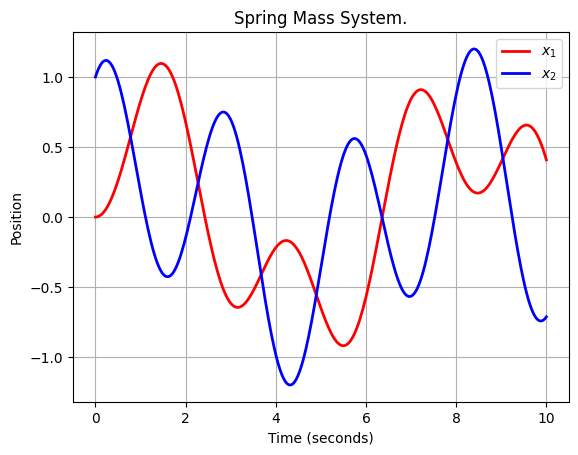

In [ ]:
plt.plot(t, x1, 'r', lw=2, label=r'$x_1$')
plt.plot(t, x2, 'b', lw=2, label=r'$x_2$')
plt.title(f'Spring Mass System.')
plt.legend()
plt.xlabel('Time (seconds)')
plt.ylabel('Position')
plt.grid()
plt.show()

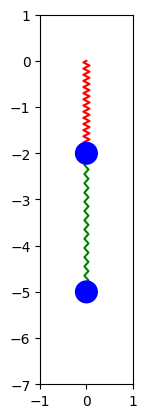

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(aspect='equal')
ax.set_xlim(-1, 1)
ax.set_ylim(-7, 1)

def generate_spring(n):
    data = np.zeros((2, n + 2))
    data[:, -1] = [0, -1]

    for i in range(1, n+1):
        data[0, i] = -1 / (2 * n) if i % 2 else 1 / (2 * n)
        data[1, i] = -(2 * i - 1) / (2 * n)
    return data

data = np.append(generate_spring(30), np.ones((1, 30 + 2)), axis=0)
data2 = np.append(generate_spring(30), np.ones((1, 30 + 2)), axis=0)

ell = 2
y0 = -(ell + x1_0)
y02 = -(ell + x2_0)
spring = Line2D(data[0, :], data[1, :], color='r')
spring2 = Line2D(data2[0, :], data[1, :], color='g')
circle = ax.add_patch(plt.Circle((0, y0), 0.25, fc='b', zorder=3))
circle2 = ax.add_patch(plt.Circle((0, y02 + y0), 0.25, fc='b', zorder=3))
ax.add_line(spring)
ax.add_line(spring2)

def animate(i):
    y = -(ell + x1[i])
    circle.set_center((0, y))

    stretch_factor = -y

    y2 = -(ell + x2[i])
    circle2.set_center((0, y2 + y))

    stretch_factor2 = -y2

    A = Affine2D().scale(8 / stretch_factor, stretch_factor).get_matrix()
    data_new = np.matmul(A, data)

    A2 = Affine2D().scale(8 / stretch_factor2, stretch_factor2).get_matrix()
    data_new2 = np.matmul(A2, data2)

    xn = data_new[0, :]
    yn = data_new[1, :]

    spring.set_data(xn, yn)

    xn2 = data_new2[0, :]
    yn2 = data_new2[1, :]

    spring2.set_data(xn2, yn2 + y)

ani = animation.FuncAnimation(fig, animate, frames=len(t))
ffmpeg_writer = animation.FFMpegWriter(fps=fps)
ani.save('2_spring_2_mass.gif', writer=ffmpeg_writer)